In [28]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns

In [29]:
# Step 2: Load Dataset
df = pd.read_csv('/content/test.csv')
print(df)
df.info()
df.describe()
df.head()
df.duplicated().sum()
df.isnull()


            ID Customer_ID      Month             Name   Age          SSN  \
0       0x160a   CUS_0xd40  September    Aaron Maashoh    23  821-00-0265   
1       0x160b   CUS_0xd40    October    Aaron Maashoh    24  821-00-0265   
2       0x160c   CUS_0xd40   November    Aaron Maashoh    24  821-00-0265   
3       0x160d   CUS_0xd40   December    Aaron Maashoh   24_  821-00-0265   
4       0x1616  CUS_0x21b1  September  Rick Rothackerj    28  004-07-5839   
...        ...         ...        ...              ...   ...          ...   
49995  0x25fe5  CUS_0x8600   December   Sarah McBridec  4975  031-35-0942   
49996  0x25fee  CUS_0x942c  September            Nicks    25  078-73-5990   
49997  0x25fef  CUS_0x942c    October            Nicks    25  078-73-5990   
49998  0x25ff0  CUS_0x942c   November            Nicks    25  078-73-5990   
49999  0x25ff1  CUS_0x942c   December            Nicks    25  078-73-5990   

      Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  .

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
49996,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
49997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
49998,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [30]:
# Step 3: Preprocessing
# ==========================
df = df.drop(['ID', 'Customer_ID', 'Month', 'Name', 'SSN'], axis=1, errors='ignore')
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna('Unknown', inplace=True)
# Encode categorical features
categorical_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [31]:
# Step 4: Define Features and Target
y = df['Credit_Mix']  # Multi-class target
X = df.drop('Credit_Mix', axis=1)
# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [32]:
# Step 5: Feature Selection
selector = RandomForestClassifier(n_estimators=100, random_state=42)
selector.fit(X, y)
sfm = SelectFromModel(selector, threshold='median')
X_selected = sfm.transform(X)
print(f"Selected Features Shape: {X_selected.shape}")

Selected Features Shape: (50000, 11)


In [33]:
# Step 6: Handle Class Imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_selected, y)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
# Binarize target for ROC-AUC
classes = np.unique(y_res)
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_train_bin.shape[1]

In [34]:
# Step 7: Define Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Logistic Regression": LogisticRegression(max_iter=2000, multi_class='multinomial', solver='lbfgs', class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}


<Figure size 1200x800 with 0 Axes>

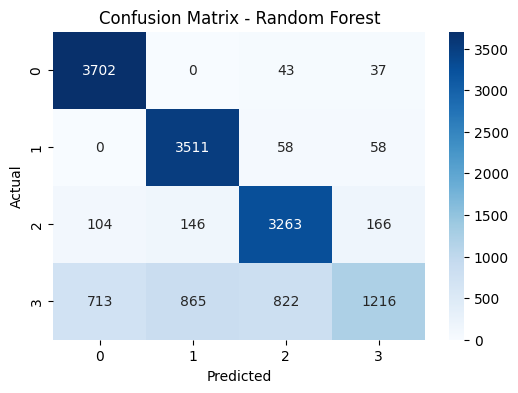

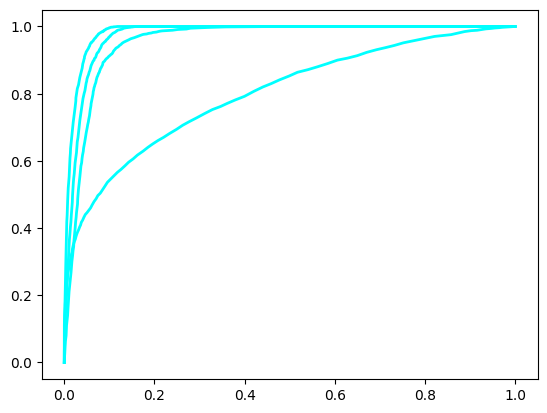

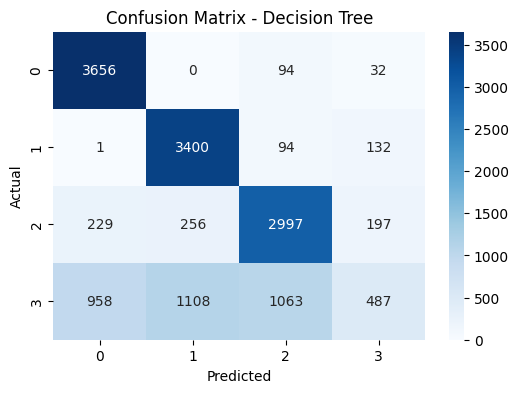

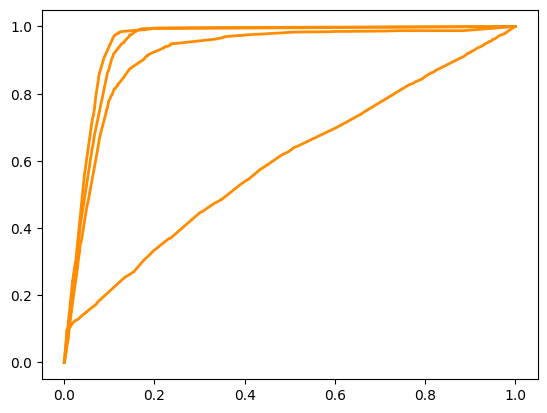

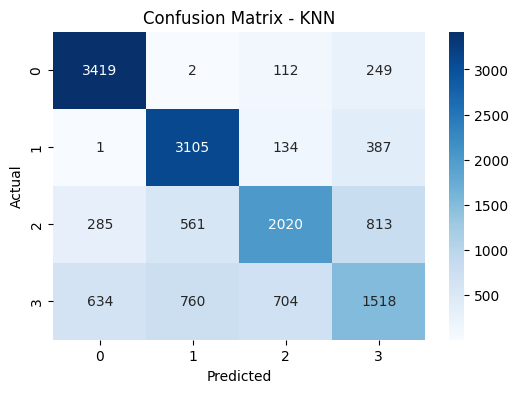

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


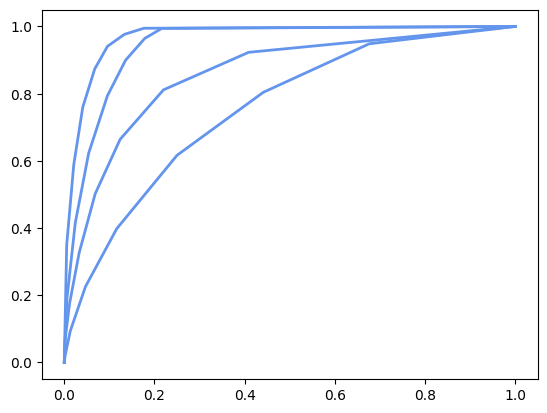

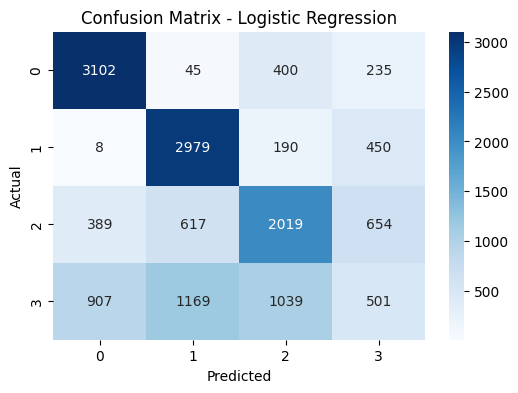

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:15:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


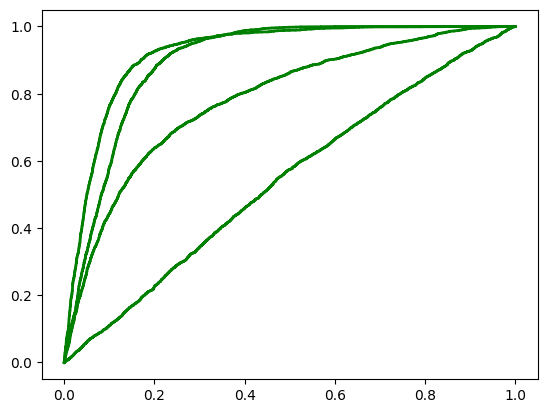

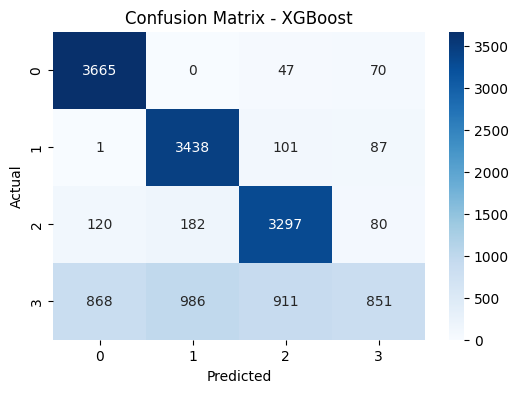

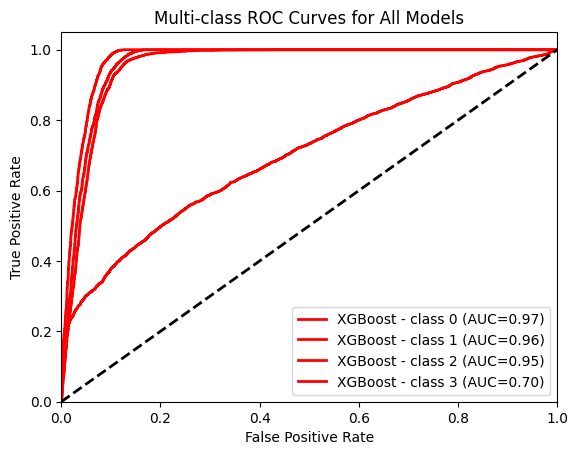

In [35]:
# Step 8: Train, Predict & Evaluate
plt.figure(figsize=(12,8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
results = []  # Store metrics for summary

for (name, model), color in zip(models.items(), colors):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision (Macro)": prec,
        "Recall (Macro)": rec,
        "F1 Score (Macro)": f1
    })

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC-AUC (One-vs-Rest)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'{name} - class {classes[i]} (AUC={roc_auc[i]:.2f})')

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()

# ==========================


In [36]:
# Step 9: Summary Report
report_df = pd.DataFrame(results)
print("===== Multi-class Classification Report for All Models =====")
print(report_df)


===== Multi-class Classification Report for All Models =====
                 Model  Accuracy  Precision (Macro)  Recall (Macro)  \
0        Random Forest  0.795158           0.799607        0.792518   
1        Decision Tree  0.716812           0.687059        0.713350   
2                  KNN  0.684304           0.670238        0.682240   
3  Logistic Regression  0.584943           0.537278        0.582221   
4              XGBoost  0.765166           0.768242        0.762116   

   F1 Score (Macro)  
0          0.765228  
1          0.658100  
2          0.670441  
3          0.549658  
4          0.721638  
